
![logo](https://www.kb.nl/sites/all/themes/kb/kblogo_en.svg)
# National Library - Koninklijke Bibliotheek


## Mining Delpher data with a Jupyter Notebook.


## Working with data from disk, using Panda's and XML parsers.

https://resolver.kb.nl/resolve?urn=DATA:kranten:kranten_pd_171x.zip

This file was downloaded and unzipped in the directory 'data'.

The structure of the Delpher downloadable set is as follows:

./README_newspapers_pd_171x.txt

./index_kranten_pd_171x.tsv

./LEESMIJ_kranten_pd_171x.txt

./README_newspapers_pd_171x.txt

./1717

./1717/02

./1717/02/02

./1717/02/02/DDD_ddd_011105161_mpeg21

./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_0007_articletext.xml

./1717/02/02/DDD_ddd_011105161_mpeg21/didl.xml

./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_002_alto.xml

It reflect's this general layout:

Toplevel has tsv and readme file,then per issue we've got a didl,

multiple alto's an multiple article-text's.

In [1]:
import time
start_time = time.time()

import os
import random
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET

from langdetect import detect
from pattern.nl import sentiment
from gensim.models import word2vec
from sklearn.decomposition import PCA

from dutch_lang import stopwords

import shutil
import nltk

In [2]:
# We'll start by reading the supplied '.tsv' file using Pandas.
# https://pandas.pydata.org/

# More info on the available files see here:
# https://www.delpher.nl/data/

BASE_PATH = 'data'
tsv = BASE_PATH + os.sep

if os.path.isdir(BASE_PATH):
    # We'll use the first file which filename ends with '.tvs' in the data dir.
    tsv += [f for f in os.listdir('data') if f.endswith('tsv')][0]
else:
    # h    ttps://resolver.kb.nl/resolve?urn=DATA:kranten:kranten_pd_1855-9.zip
    print("Please download & unpack data file: https://resolver.kb.nl/resolve?urn=DATA:kranten:kranten_pd_171x.zip")

In [3]:
# Do the actual loading of the '.tsv' file, using custom colum names.
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

df = pd.read_csv(tsv, sep='\t', names=["name","period", "zip_name", "path"])
tsv

'data/index_kranten_pd_1865-9.tsv'

## What period is covered?

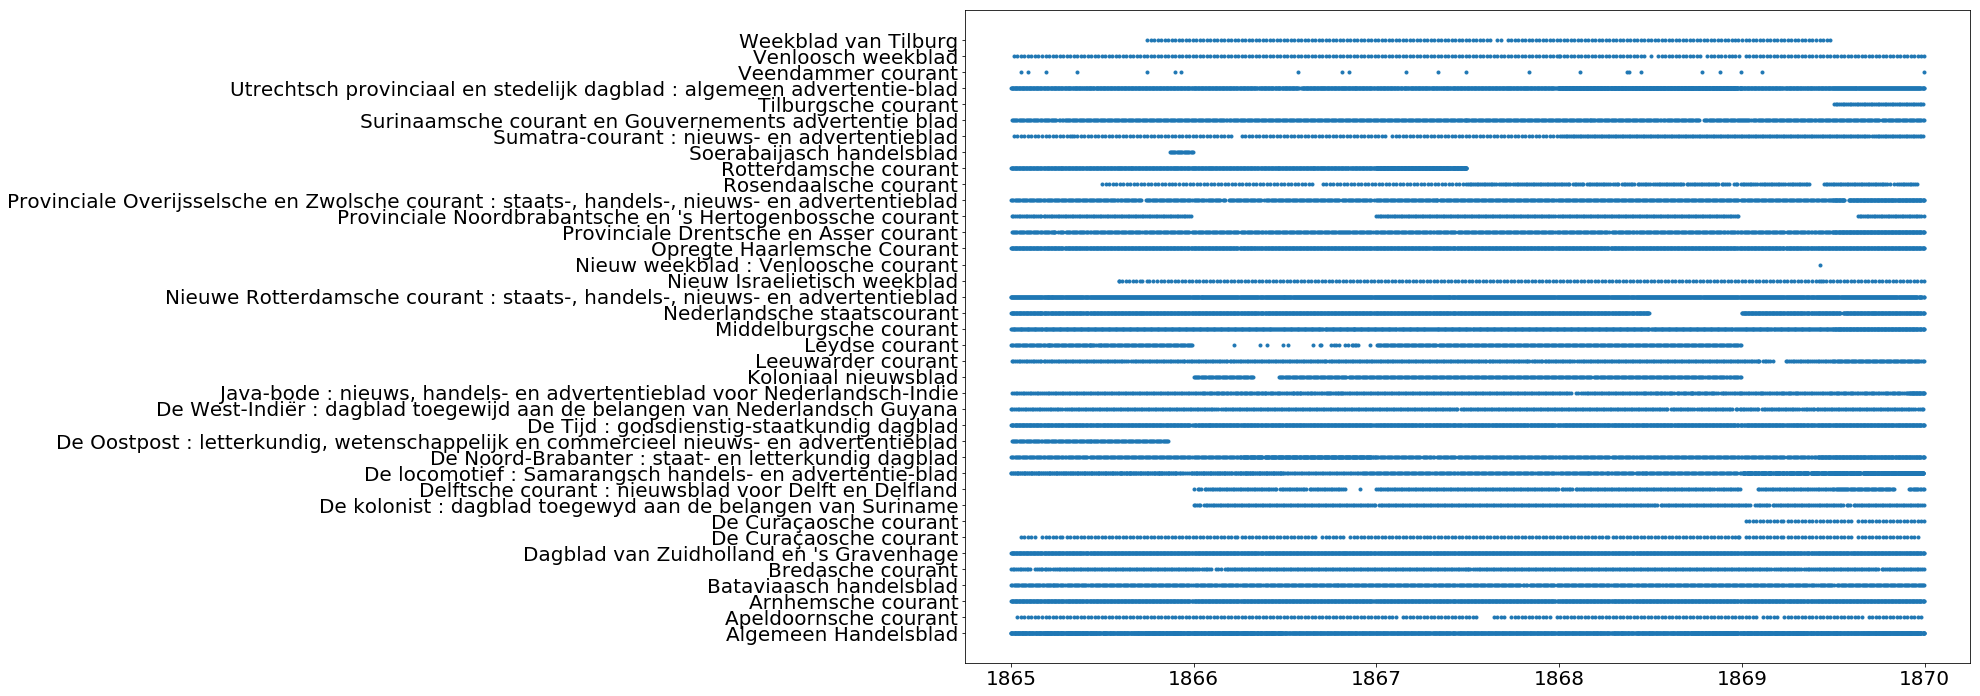

In [4]:
import matplotlib.pyplot as plt

df['period']= pd.to_datetime(df['period'], format='%Y-%m-%d')
df.set_index(df['period'],inplace=True)
plt.figure(figsize=(18, 12))
plt.rcParams.update({'font.size': 20})

plt.plot(df['period'], df['name'], '.')

## What newspaper titles are in this zip file?

In [5]:
list(df.name.unique())

['Algemeen Handelsblad',
 'Apeldoornsche courant',
 'Arnhemsche courant',
 'Bataviaasch handelsblad',
 'Bredasche courant',
 "Dagblad van Zuidholland en 's Gravenhage",
 'De Curaçaosche courant',
 'De Curaçaosche courant',
 'De kolonist : dagblad toegewyd aan de belangen van Suriname',
 'Delftsche courant : nieuwsblad voor Delft en Delfland',
 'De locomotief : Samarangsch handels- en advertentie-blad',
 'De Noord-Brabanter : staat- en letterkundig dagblad',
 'De Oostpost : letterkundig, wetenschappelĳk en commercieel nieuws- en advertentieblad',
 'De Tĳd : godsdienstig-staatkundig dagblad',
 'De West-Indiër : dagblad toegewĳd aan de belangen van Nederlandsch Guyana',
 'Java-bode : nieuws, handels- en advertentieblad voor Nederlandsch-Indie',
 'Koloniaal nieuwsblad',
 'Leeuwarder courant',
 'Leydse courant',
 'Middelburgsche courant',
 'Nederlandsche staatscourant',
 'Nieuwe Rotterdamsche courant : staats-, handels-, nieuws- en advertentieblad',
 'Nieuw Israelietisch weekblad',
 'Nieu

In [6]:
# For speed-sake we start off with a small set.
#
#
mask = (df['period'] > '1865-01-01') & (df['period'] < '1865-10-01')
       
wanted_paths = [BASE_PATH + os.sep + f[2:] for f in list(df[mask]["path"])]

# If you want to use all, uncomment the next line.
# wanted_paths = [BASE_PATH + os.sep + f[2:] for f in list(df["path"])]

article_strings = [] # Store all article texts in a list().
article_by_date = {} # Also store all articles with pubish_date as reference.

used_files = set()

for path in sorted(wanted_paths):
    # A newspaper 'issue' consists of multiple articles,
    # here we read all of it into a long list.
    #
    # You could apply a fiter for article headings and contents here,
    # Look into one of the _articletext.xml files to get an idea of
    # the structure.
    
    
    # The following little hack is here because of limited disk-space available,
    # also working with huge data-set's on this relativly small setup is no fun.
    if not os.path.isdir(path):
        #print("Skipping: %s" % path)
        continue

    text_files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('_articletext.xml')]
        
    for file_name in text_files:
        # This is used later on, only for pre-processing.
        used_files.add(file_name)
    
    # If you want to keep track of how many articles there are per 'issue', 
    # this is an example:
    
    # article_count.append(len(text_files))
    
    block_list = ['dito']
    
    for file_name in text_files:
        #print("Reading: %s" % file_name)
        # Read the XML file using lxml parser.
        tree = ET.parse(file_name)
        for item in tree.iter():
            if item.text and item.text.strip():
                
                blocked = False
                
                for block_word in block_list:
                    if item.text.lower().find(block_word) > -1:
                        blocked = True
                        
                if not blocked:
                    # Here we could analyze each peace of text,
                    # to see weather it is dutch or french.
                    # if detect(item.text) == 'nl':
                
                    # For now we'll jus add them all to list().
                    article_strings.append(item.text)
                
                    # Derive the publish_date from file_name
                    publish_date = file_name.split('/')[1] + '_'
                    publish_date += file_name.split('/')[2] + '_'
                    publish_date += file_name.split('/')[3]
                
                    if not publish_date in article_by_date:
                        article_by_date[publish_date] = [item.text]
                    else:
                        article_by_date[publish_date].append(item.text)
                
#df.append(pd.DataFrame(article_count, lang_list, columns=['num_articles', 'lang_list']))

    

In [7]:
print(article_strings[:10])

['Rivierberigten.', "ARNHEM, 31 Dec. Rijnhoogte 4 p. 8 d. onder 0, gev. 8 d. KEULEN, 31 Dec. Rijnhoogte: 1 vt, Kculsch. Er'komt iets meer en sterker ijs af. Op de overige punten langs den Rijn,is weinig verandering sints gisteren. ___^", 'UITGEZEILD.', 'HAMBURG, 30 Dcc; Hammonia, S., Rott. GLUCKSTADT, 31 Dcc; Stoomvaart, S., Amst. DARTMOUTH, 28 Dcc; Maria, v. Wulven, Bnenos-Ayrcs n. Amst. GRANTON, 27 Dcc; Annechina Henrictte, v. d. Moulen, Pillau naar Bremen. - Jantina; Schoon, Kiel n. Brugge. - Unie, Posta, Dantz. n. Harl. - Fenna, Coerkamp, Kjöge n. Londen. HARWICH, 27 Deo.; Lily, Calthoi-pe, Rott. n. Yarmouth. PORTSMOUTH, 28 Dcc; Fortuna, Höster, Sevilla n. Antw. ANTWERPEN, 31 Dcc; Terschelling, Rotgans, Para. St. NAZAIRE, 28 Dcc; Mélanie Héloise, Vallée Harlingen.', 'BERIGTEN UIT DE LAATSTE EDITIE VAN HET VORIG NOMMER OVERGENOMEN.', "* ROTTERDAM, 31 Dec. Niettegenstaande het dezen nacht wederom cenigzins heeft gevroren, heeft het ijs zich boven deze stad in beweging gezet en is doo

{'1865/01': 3444, '1865/02': 3022, '1865/03': 3443, '1865/04': 2811, '1865/05': 3468, '1865/06': 2887, '1865/07': 3548, '1865/08': 3387, '1865/09': 3766}


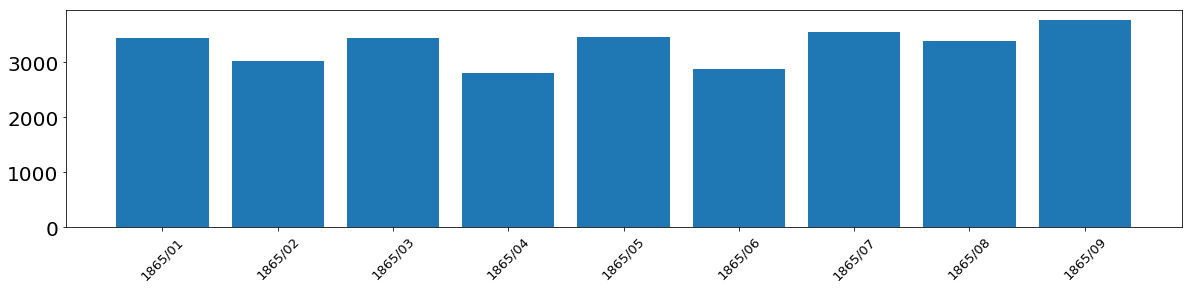

In [8]:
# Show the number of articles per month.

date_freq = {}
for date in article_by_date:
    odate = date
    date = date.split('_')[0] + "/"
    date += odate.split('_')[1]
    
    if not date in date_freq:
        date_freq[date] = len(article_by_date[odate])
    else:
        date_freq[date] += len(article_by_date[odate])
print(date_freq)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,4))
names = list(date_freq.keys())
values = list(date_freq.values())

#tick_label does the some work as plt.xticks()
plt.bar(range(len(date_freq)),values,tick_label=names)
ax.set_xticklabels(names, fontsize=13)
ax.set_xticklabels(names, rotation=45)
plt.show()

In [9]:
def split_files():
    '''
        This function was only used in pre-processing,
        to seperate file's we use and file's we don't.
    '''      
    import shutil
    for dirname in set([f for f in used_files]):
        try:
            shutil.move(dirname, "used/" + dirname)
        except:
            os.makedirs('used/' + os.path.dirname(dirname))
            shutil.move(dirname, "used/" + dirname)

## Using sentiment for splitting the text into, positive and negative

In [10]:
## Negative first

# Here we use pattern's sentiment analysis component,
# to assess if an article is negative.
print(len(article_strings))

print(sentiment(article_strings[0]))

# In the intrest of time, limt the number of 
dirt = [a for a in article_strings if sentiment(a)[0] < -0.1]
# The list() dirt only contains articles with negative sentiment.

print(len(dirt))
print(dirt[0])
print(dirt[-1])


29776
(0.0, 0.0)
3724
> PARIJS, 31 Dec. Het gerucht dat de minister van buitenlandsehe zaken, eene depêche heeft gezonden aan den Heer de Sartiges, Fransch ambassadeur bij den pauselijken stoel, betreffende do jongste encyclica bevestigt zich. De minister geeft daarin het leedwezen der regering te kennen over dien stap door den Paus, gedaan en zegt dat met grond mag worden voorzien, dat de indruk door den inhoud der encyclica te weeg «-el-ragt in Frankrijk, zeer ongunstig voor den Paus zal zijn. MARSEILLE, 31 Dcc Volgons medcdeclingen uit Napels, geclas'teekend 28 jl., heeft Prins Hum'bert een bezoek afgelegd bij den kardinaal Andrea. Op 18 e. k. wordt do Grootvorst-Troonopvolger te Napels verwacht. Er zal na de komst van den Grootvorst eene wapenschouwing worden gehouden over 100 bataillons der nationale garde. Uit Rome wordt dd. 28 jl. gemeld, dat do Paus op het Kersfeest door de leden van het collegic van kardinalen is bezocht. In antwoord op de toespraak tot hem gerigt door den dek

In [11]:
word_list = {}
sentences = []

for article in dirt:
    article = article.replace('. ', ' ').replace('.',' ').strip()    
    sent = []
    
    for word in article.split(' '):
        if word.strip() and word.strip()[0].isalpha():
            if not word in word_list:
                word_list[word] = 0
            else:
                word_list[word] += 1
            if len(word) > 3 and not word.lower() in stopwords:
                sent.append(word)
    sentences.append(sent)

print([(w,word_list[w]) for w in word_list if word_list[w] > 11 and word_list[w] < 40 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])
neg = set([w for w in word_list if word_list[w] > 11 and word_list[w] < 40 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])

[('Fransch', 26), ('Frankrijk,', 19), ('MARSEILLE,', 37), ('Napels', 23), ('Alexander', 33), ('Nederlanden,', 21), ('Straat', 12), ('Rees,', 15), ('Metalen', 17), ('Muller,', 32), ('Zuid-', 25), ('Borneo,', 24), ('Zuiden', 27), ('Riouw', 15), ('Celebes', 22), ('Westkust', 21), ('Morgen', 35), ('Dezer', 29), ('Vlaardingen', 12), ('Singapore', 39), ('Hongkong', 19), ('Gezusters,', 34), ('Sleeswijk', 13), ('Hansen,', 28), ('Stokholm', 12), ('Poolsche', 20), ('Keizer,', 13), ('Warschau', 18), ('ZWART', 27), ('Paard', 36), ('Kgin', 36), ('Pion', 30), ('Koolzaad', 20), ('Hoogste', 30), ('LEEUWARDEN,', 12), ('Leeuwarden,', 16), ('Helena,', 29), ('Jacoba,', 34), ('Breda', 18), ('Zoodra', 15), ('Waterstand', 13), ('HELVOETSLUIS,', 23), ('Rijn', 38), ('Oost-Indie', 16), ('Trein', 29), ('Nederlandsch', 24), ('BARKSCHIP', 29), ('DIENST', 18), ('TUSSCHEN', 22), ('PASSAGIERS', 35), ('GOEDEREN', 23), ('Vertrek', 36), ('Agenten', 28), ('Gouda', 13), ('Zware', 38), ('IJssel', 12), ('Directeur', 13), ('

## Using word2vec to get an idea of the corpus

In [12]:
# Here we feed the negative sentences into word2vec.
#
# https://en.wikipedia.org/wiki/Word2vec
#

model = word2vec.Word2Vec(sentences, size=100, window=5, min_count=20, workers=4)

In [13]:
# In order to make a visual representation of the word2vec model,
# we'll have to reduce the number of axis in the model, often PCA is used.

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
words = list(model.wv.vocab)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


## Word2Vec visualization words for negative sentences

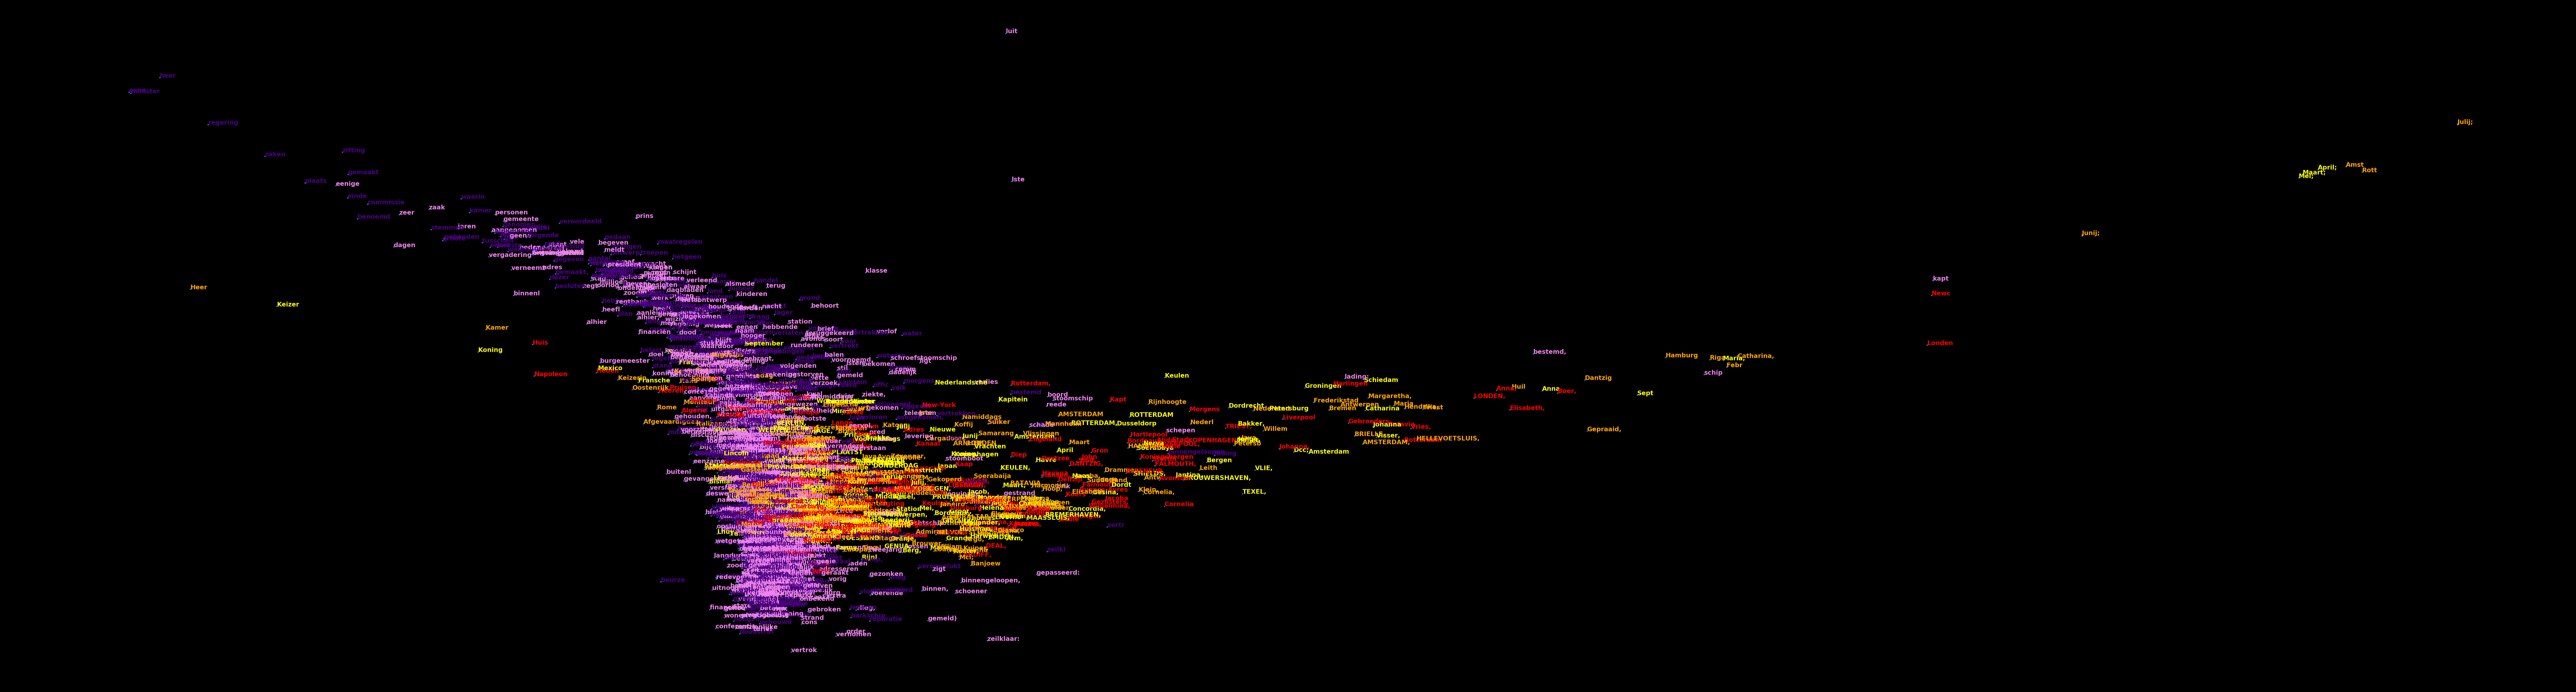

In [14]:
# Create a scatter plot of the projection
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'black'
plt.figure(figsize=(220, 60), facecolor="black")
plt.rcParams["font.size"] = 30
plt.rcParams["font.weight"] = "bold"

wanted_x = []
wanted_y = []

for i, word in enumerate(words):
    if word == "Dito":
        continue
    if word[0].isupper():
        c = random.choice(["red", "orange", "yellow"])
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), color=c)
        wanted_y.append(result[i,1])
    else:
        c = random.choice(["indigo", "violet"])
        plt.annotate(word, xy=(result[i, 0], result[i, 1]*2), color=c)
        wanted_y.append(result[i,1]*2)
    wanted_x.append(result[i,0])
    
    
plt.scatter(wanted_x, wanted_y)
plt.show()

# open the image below in new browser window for full detail.

In [15]:
words

['PARIJS,',
 'gerucht',
 'minister',
 'zaken,',
 'eene',
 'gezonden',
 'Heer',
 'Fransch',
 'jongste',
 'encyclica',
 'geeft',
 'regering',
 'kennen',
 'gedaan',
 'zegt',
 'grond',
 'voorzien,',
 'indruk',
 'inhoud',
 'Frankrijk,',
 'zeer',
 'ongunstig',
 'Paus',
 'MARSEILLE,',
 'Prins',
 'bezoek',
 'afgelegd',
 'Napels',
 'verwacht',
 'komst',
 'gehouden',
 'nationale',
 'Rome',
 'gemeld,',
 'bezocht',
 'antwoord',
 'kerk',
 'allen',
 'waarop',
 'plaats',
 'hebben,',
 'zekerheid',
 'aangewezen',
 'vrede',
 'corps',
 'ontvangen,',
 'bevond',
 'Russische',
 'gezant',
 'dagteekening',
 'ontvangen',
 'navolgende',
 'schepen,',
 'eskader',
 'Alexander',
 'Nederlanden,',
 'kapt',
 'wachtschip',
 'korvet',
 'brik',
 'luit',
 'lste',
 'Kapt',
 'Japan',
 'Batavia',
 'Iste',
 'behoort',
 'zeemagt',
 'wateren',
 'stoomschip',
 'Amsterdam,',
 'Muller,',
 'Koning,',
 'Soerabaya',
 'gereed',
 'gemaakt',
 'reis',
 'bestemming',
 'reparatie',
 'Nederland',
 'Zuid-',
 'gestationeerd',
 'togt',
 'stati

In [16]:
model.wv.similarity("Java", "militaire")


0.46950822970889555

In [17]:
## Now we will do the same for positive news.
yeaah = [a for a in article_strings if sentiment(a)[0] > 0.1]

In [18]:
word_list = {}
sentences = []
for article in yeaah:
    article = article.replace('. ', ' ').replace('.',' ').strip()
    
    sent = []
    
    for word in article.split(' '):
        if word.strip() and word.strip()[0].isalpha():
            if not word in word_list:
                word_list[word] = 0
            else:
                word_list[word] += 1
            if len(word) > 3 and not word.lower() in stopwords:
                sent.append(word)
    sentences.append(sent)
     
print([(w,word_list[w]) for w in word_list if word_list[w] > 50 and word_list[w] < 1000 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])
pos = set([w for w in word_list if word_list[w] > 80 and w[0].isupper() and word_list[w] < 100 and len(w) >3 and not w.lower() in stopwords])

[('Vrijdag', 350), ('Zaturdag', 484), ('Arnhem', 244), ('December', 211), ('Limburg', 55), ('Zeer', 113), ('Goed', 56), ('Rusland', 52), ('Koning', 345), ('Italië', 67), ('Berlijn', 71), ('Keizer', 230), ('Januarij', 902), ('Parijs', 304), ('Iste', 64), ('Zondag', 211), ('November', 355), ('Brussel', 101), ('PARIJS,', 63), ('Frankrijk,', 55), ('Kleine', 57), ('Hoer', 62), ('Donderdag', 467), ('Hoogduitsche', 94), ('Woensdag', 488), ('Morgen', 68), ('Salon', 58), ('Paris', 69), ('Dames', 265), ('Kind', 75), ('Paleis', 182), ('Frankrijk', 188), ('Gisteren', 184), ('Deventer,', 104), ('Hoorn,', 89), ('Meijer,', 64), ('Amsterdam;', 99), ('Willem', 136), ('Leyden;', 55), ('Hendrik', 55), ('Rotterdam', 757), ('Zwolle', 147), ('Maria', 106), ('Maatschappij', 369), ('MAANDAG', 225), ('Cents', 908), ('Begunstigers', 185), ('Vrienden', 114), ('Amstekdam,', 94), ('FABRIEK', 95), ('Deventer', 99), ('LEPPER', 87), ('ZOON,', 847), ('Rokin', 106), ('Stad', 376), ('AMSTERDAM', 430), ('Fatsoenlijk', 12

In [19]:
# Here we feed the positive sentences into word2vec.
#
# https://en.wikipedia.org/wiki/Word2vec
#

model = word2vec.Word2Vec(sentences, size=100, window=5, min_count=20, workers=4)

In [20]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
words = list(model.wv.vocab)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


## Word2Vec visualization words for positive sentences

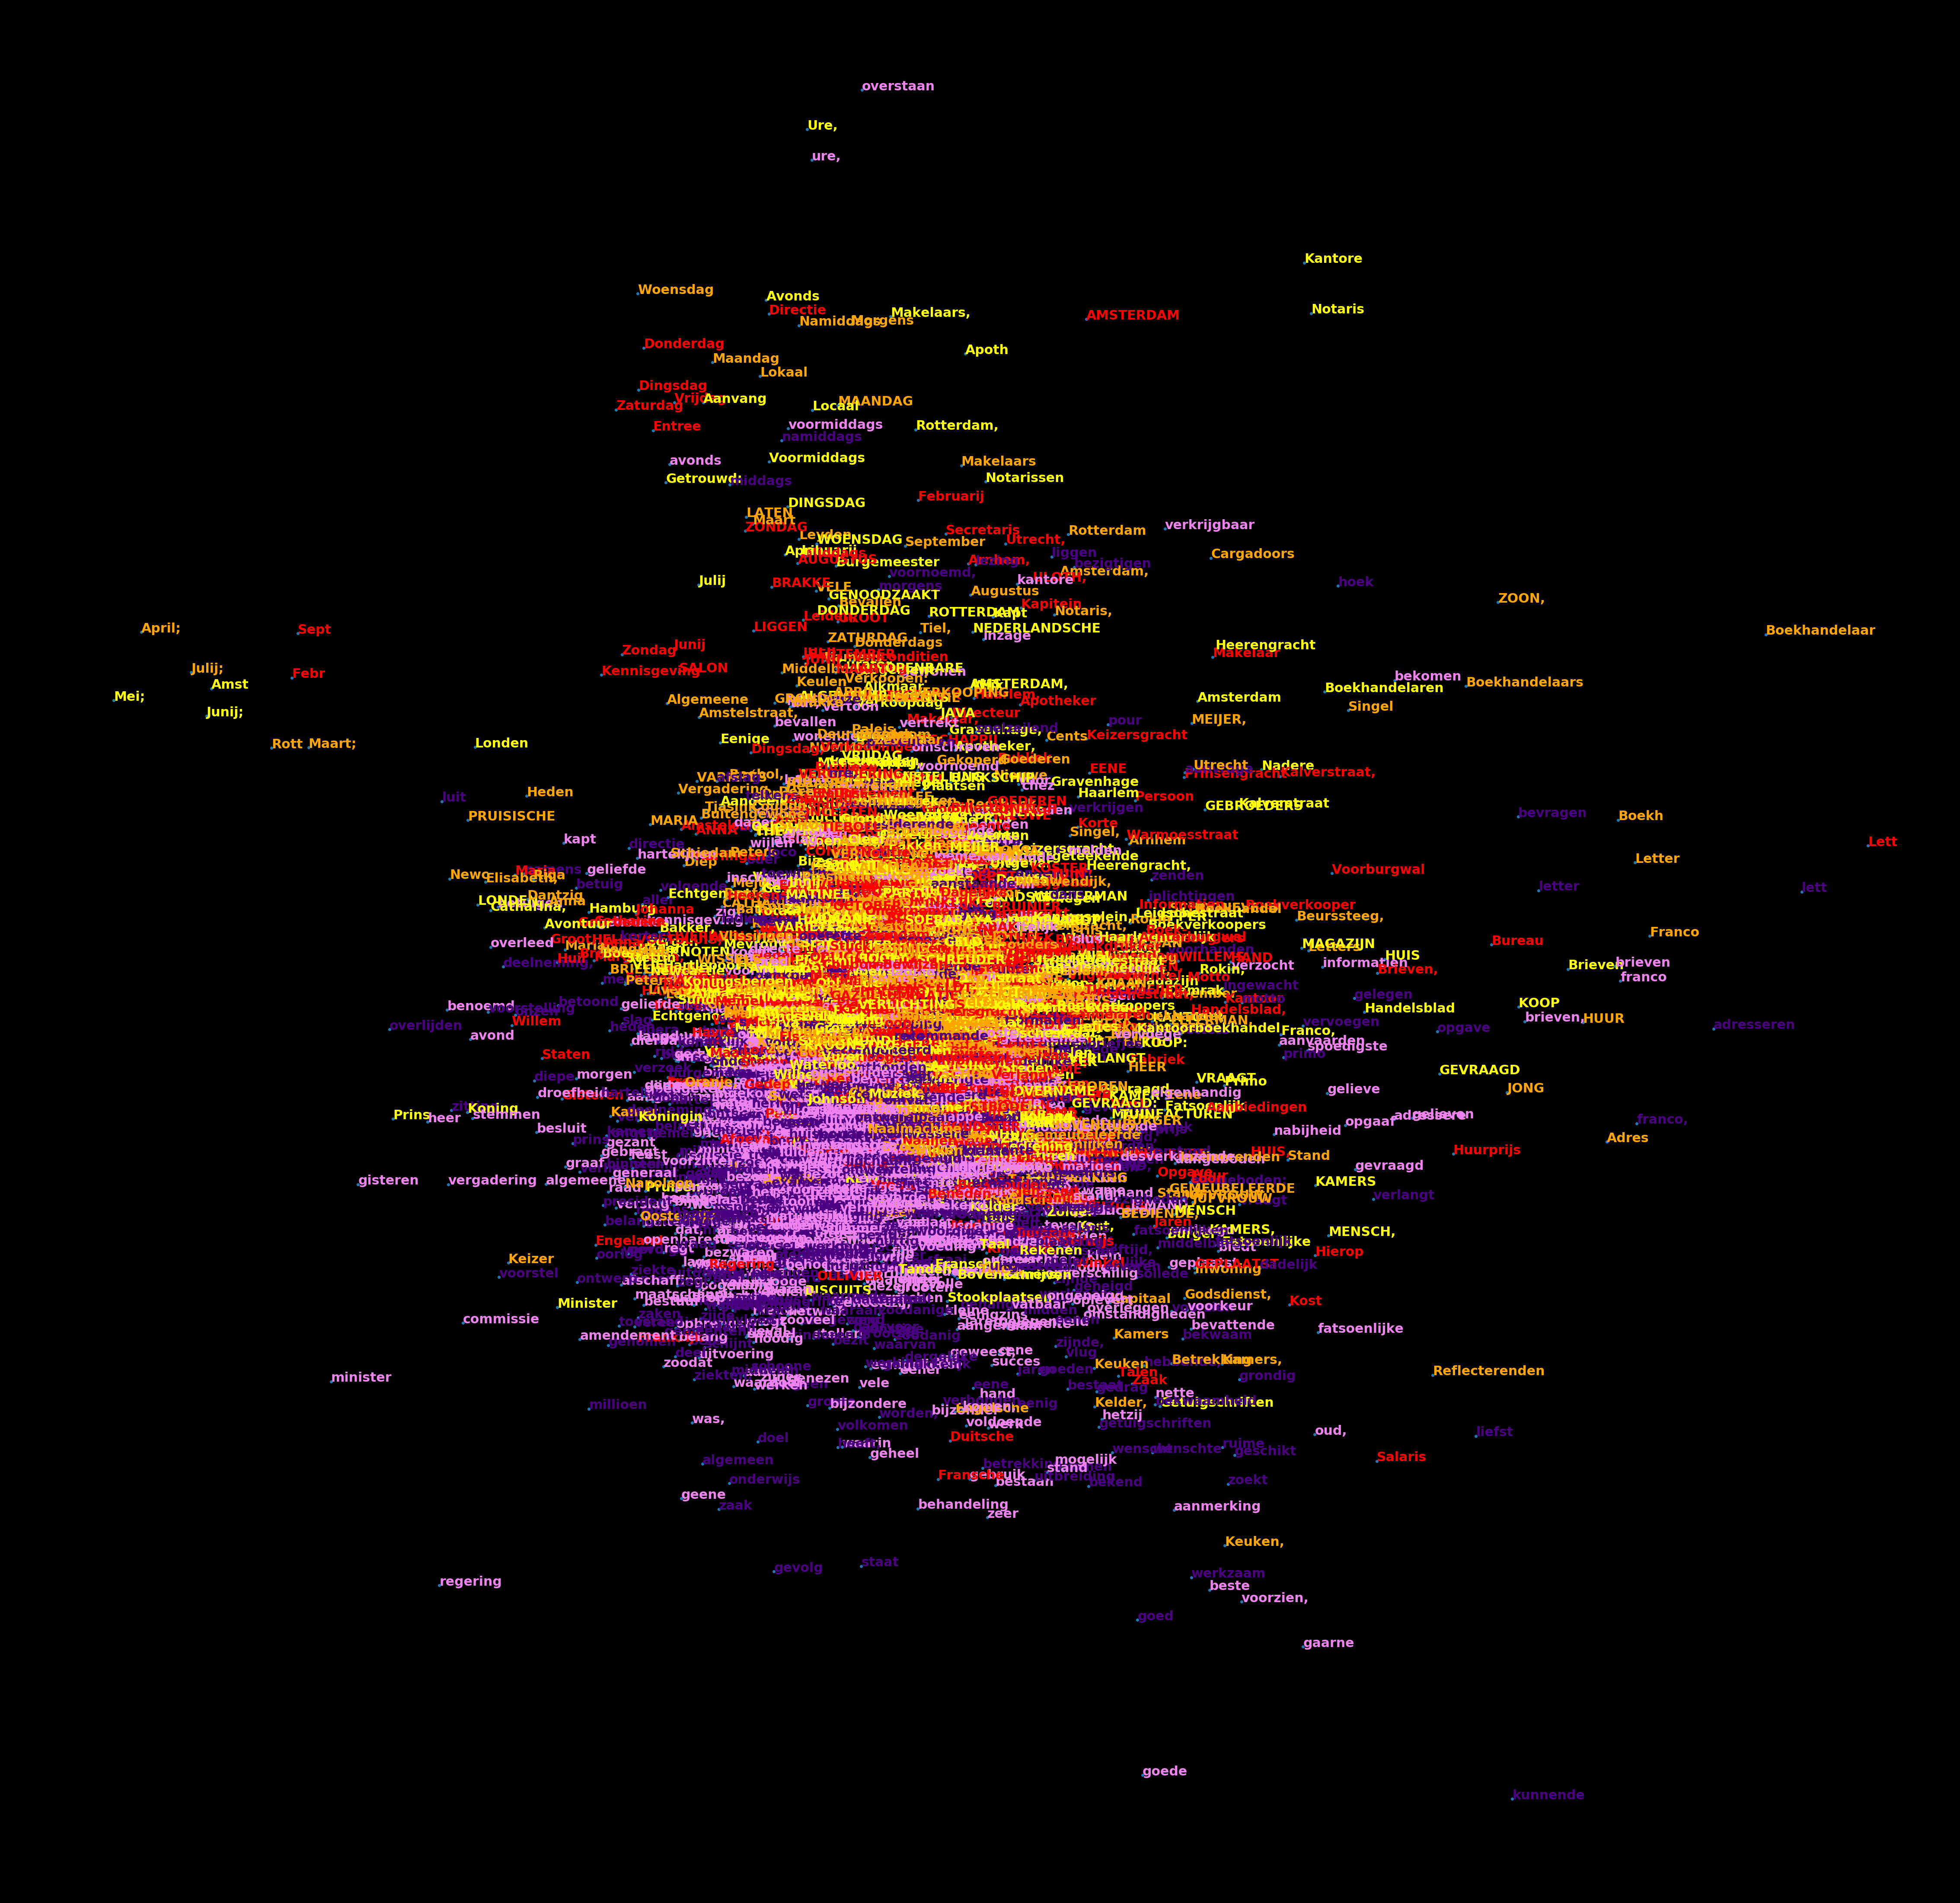

In [21]:
# Create a scatter plot of the projection
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'black'
plt.figure(figsize=(80, 80), facecolor="black")
plt.rcParams["font.size"] = 30
plt.rcParams["font.weight"] = "bold"

wanted_x = []
wanted_y = []

for i, word in enumerate(words):
    if word.lower() in ["zoon"]:
        continue
    if word[0].isupper():
        c = random.choice(["red", "orange", "yellow"])
    else:
        c = random.choice(["indigo", "violet"])
        
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), color=c)
    wanted_x.append(result[i,0])
    wanted_y.append(result[i,1])
plt.scatter(wanted_x, wanted_y)
plt.show()

## Wordclouds

In [22]:
from wordcloud import WordCloud
print(pos)


{'KAMER', 'Bediening', 'Gebroeders,', 'Tevens', 'CORNELIS', 'VERLANGT', 'Amsterdam;', 'Bergen', 'PLAATS', 'ATTENTIE', 'Haarlemmerdijk', 'Stuk', 'Stalling', 'ELLERMAN,', 'Amstekdam,', 'Doctor', 'Gulden', 'JULIJ', 'Londen,', 'Fijne', 'Klasse', 'Vries,', 'Rijn', 'Sacramenten', 'Chir', 'Batavia', 'Deventer', 'Hoorn,', 'Breda,', 'HEEREN', 'Opgave', 'TENTOONSTELLING', 'Inrigting', 'België', 'TEXEL,', 'Amstelstraat,', 'Batavia,', 'Avontuur', 'Koop', 'FABRIEK', 'KOSTER', 'Gouda', 'Inlichtingen', 'Koffij', 'WESTERMAN', 'BANKNOTEN', 'PLAATSGEBREK', 'Nederland,', 'Broeder', 'Burg', 'WERK', 'Vijgendam', 'Voorwaarden', 'WISSELS', 'Koningin', 'Buitengewone', 'Boer,', 'Brakke', 'Agenten', 'Hoogduitsche', 'HELLEVOETSLUIS,', 'New-York', 'ECHTVEREENIGING', 'ROTTERDAM,', 'Kost,', 'LIGGEN', 'Dantzig', 'Warmoesstraat,', 'Vrouwe', 'Provincie', 'ZATURDAG', 'Boek-', 'VRIES,', 'BEDIENDE,', 'BATAVIA', 'Zoon,', 'Boekverkoopers', 'Breda', 'Nieuwendijk,', 'Gevraagd', 'KOSTER,', 'Amsterdamsche', 'Flacon', 'BETREKKI

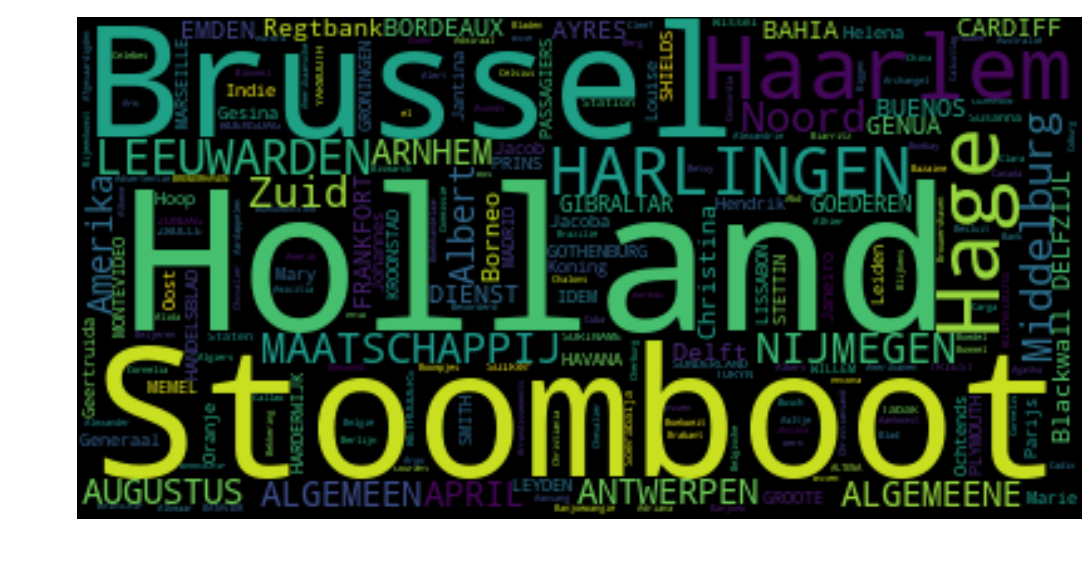

In [23]:
# Positive only
wordcloud = WordCloud().generate(str([w + " " for w in sorted(neg-pos)]))
                                                      
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.axis("off")

plt.imshow(wordcloud, interpolation='bilinear')


In [24]:
stop_time = time.time()
print((stop_time - start_time )/ 60.0)

8.507331844170889
